In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.patches as pth
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import ImageGrid

Text(0.5, 1.0, 'Vertical frame')

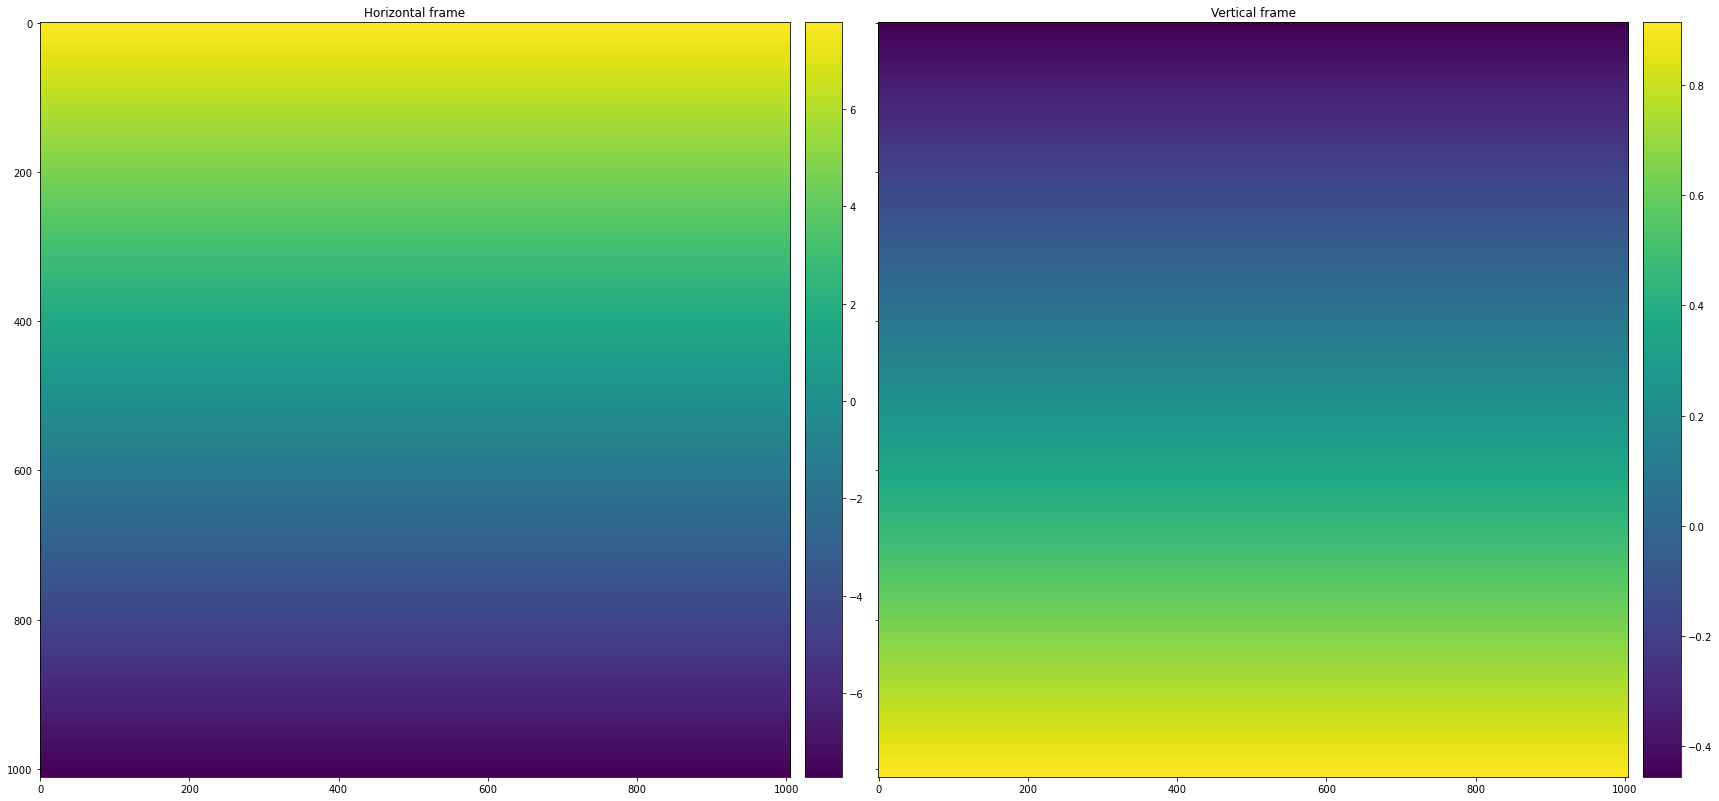

In [2]:
#load the displacement field.
hdispx = np.load("hori dispx.npy")
hdispy = np.load("hori dispy.npy")
fig =plt.figure(1, figsize=(100, 50))
grid=ImageGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(hdispx, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Horizontal frame')
im=grid[1].imshow(hdispy, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Vertical frame')

In [74]:
def RowFitConstraint(frame, pieces):
    row = int(frame.shape[0])
    col = int(frame.shape[1])
    piece_len = col/pieces
    piece_hlen = int(np.floor(piece_len/2))
    bound_pts = np.zeros((pieces + 2,), np.int32)
    bound_pts[pieces+1] = col
    shift_val = (col - piece_len*pieces)/2 + piece_hlen
    bound_pts[1:pieces+1] = np.arange(pieces)*piece_len + shift_val
    #start constraint.
    constrained = np.zeros(frame.shape, np.float32)
    for i in range(row):
        avg_values = np.zeros(pieces + 1, np.float32)
        slp_values = np.zeros(pieces + 1, np.float32)
        for j in range(pieces):
            avg_values[j + 1] = np.average(frame[i, (bound_pts[j+1]-piece_hlen):(bound_pts[j+1]+piece_hlen+1)])
        for j in range(pieces-1):
            slp_values[j + 1] = (avg_values[j+2] - avg_values[j+1])/(bound_pts[j+2] - bound_pts[j+1])
        slp_values[0] = slp_values[1]
        slp_values[pieces] = slp_values[pieces - 1]
        avg_values[0] = avg_values[1] - slp_values[0]*bound_pts[1]
        #start linear fitting.
        for j in range(pieces + 1):
            constrained[i, bound_pts[j]:bound_pts[j+1]] = avg_values[j] + slp_values[j]*np.arange(0, bound_pts[j+1] - bound_pts[j])
    return constrained
def ColFitConstraint(frame, pieces):
    row = int(frame.shape[0])
    col = int(frame.shape[1])
    piece_len = row/pieces
    piece_hlen = int(np.floor(piece_len/2))
    bound_pts = np.zeros((pieces + 2,), np.int32)
    bound_pts[pieces+1] = row
    shift_val = (row - piece_len*pieces)/2 + piece_hlen
    bound_pts[1:pieces+1] = np.arange(pieces)*piece_len + shift_val
    constrained = np.zeros(frame.shape, np.float32)
    for i in range(col):
        avg_values = np.zeros(pieces + 1, np.float32)
        slp_values = np.zeros(pieces + 1, np.float32)
        for j in range(pieces):
            avg_values[j + 1] = np.average(frame[(bound_pts[j+1]-piece_hlen):(bound_pts[j+1]+piece_hlen+1), i])
        for j in range(pieces-1):
            slp_values[j + 1] = (avg_values[j+2] - avg_values[j+1])/(bound_pts[j+2] - bound_pts[j+1])
        slp_values[0] = slp_values[1]
        slp_values[pieces] = slp_values[pieces - 1]
        avg_values[0] = avg_values[1] - slp_values[0]*bound_pts[1]
        #start linear fitting.
        for j in range(pieces + 1):
            constrained[bound_pts[j]:bound_pts[j+1], i] = avg_values[j] + slp_values[j]*np.arange(0, bound_pts[j+1] - bound_pts[j])
    return constrained

In [75]:
constrained = ColFitConstraint(hdispy, 4)

Text(0.5, 1.0, 'Vertical frame')

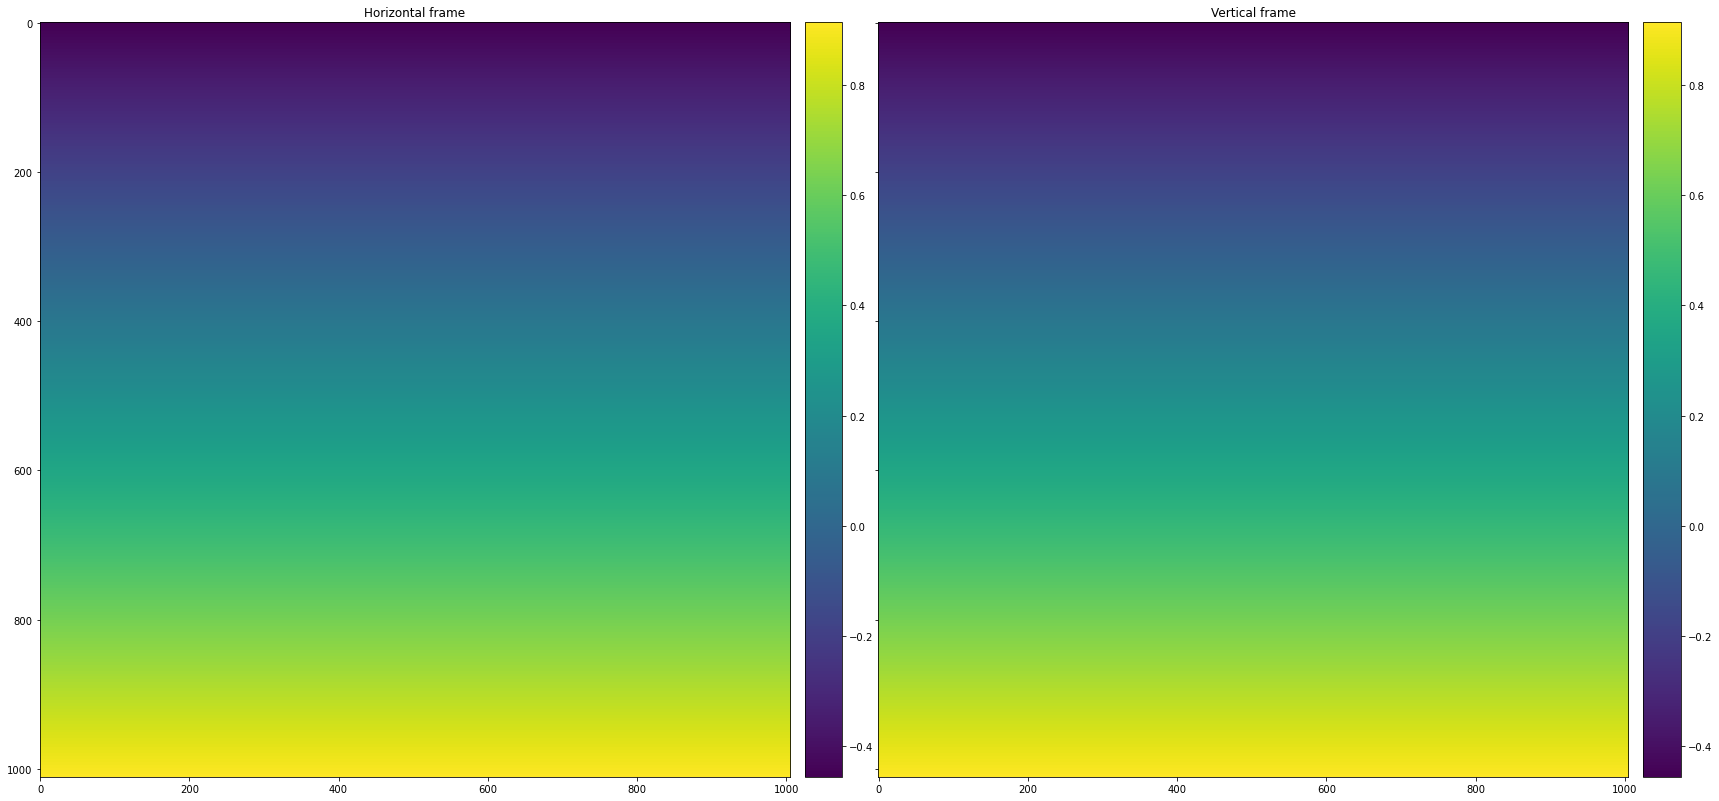

In [76]:
fig =plt.figure(1, figsize=(100, 50))
grid=ImageGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(hdispy, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Horizontal frame')
im=grid[1].imshow(constrained, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Vertical frame')

In [78]:
#generate a Gaussian blob
Y, X = np.indices(hdispx.shape)
X = X- np.average(X)
Y = Y- np.average(Y)
disp = np.exp(-(X**2+ Y**2)/10000.0)
constraint = ColFitConstraint(disp, 5)

Text(0.5, 1.0, 'Vertical frame')

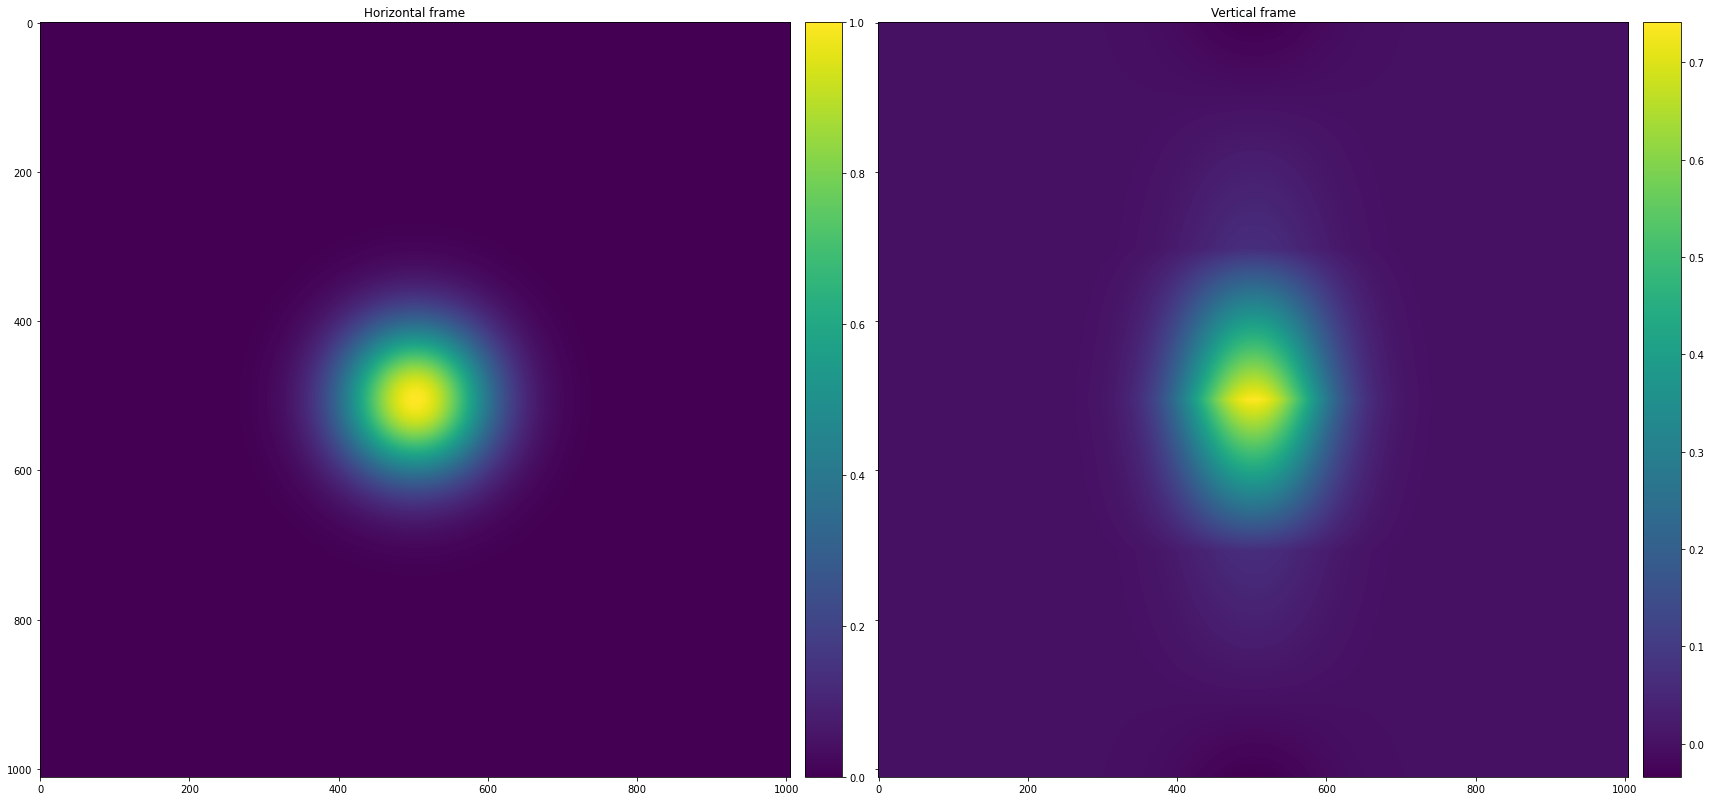

In [79]:
fig =plt.figure(1, figsize=(100, 50))
grid=ImageGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(disp, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title('Horizontal frame')
im=grid[1].imshow(constraint, cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title('Vertical frame')